In [1]:
import pandas as pd
from polyleven import levenshtein
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load data for hospitalization and merge with cluster
df = pd.read_excel('Denmark hospitalization.xlsx')
print(df)
df = df.iloc[:,0:4]
df = df.sort_values('Date')

# Group by 'date' and 'region', and calculate the sum of 'cases'
df2 = df.groupby(['Date'])['Hospitalization'].sum().reset_index()

df2 = df2.sort_values('Date')
# Calculate the 7-day moving average
df2['7_avg'] = df2['Hospitalization'].rolling(window=7, min_periods=1).mean().reset_index(drop=True)
# Set 'date' as the index of the DataFrame
df2.set_index('Date', inplace=True)

# Resample 'hospitalization' column by week and calculate the sum
# 'W' stands for weekly frequency
# 'W-SUN' means weeks are defined to start on Sunday
dfhosp = df2['Hospitalization'].resample('W-MON').sum()

# Reset the index of the new DataFrame
dfhosp = dfhosp.reset_index()
# Rename 'date' column to 'week'
dfhosp.rename(columns={'date': 'week'}, inplace=True)
print(dfhosp)

      Regionskode       Region       Date  Hospitalization  \
0            1084  Hovedstaden 2020-03-01                1   
1            1084  Hovedstaden 2020-03-03                1   
2            1084  Hovedstaden 2020-03-05                1   
3            1084  Hovedstaden 2020-03-06                3   
4            1085     Sj�lland 2020-03-06                1   
...           ...          ...        ...              ...   
6672         1084  Hovedstaden 2024-05-09                4   
6673         1085     Sj�lland 2024-05-10                1   
6674         1083   Syddanmark 2024-05-10                1   
6675         1084  Hovedstaden 2024-05-11                1   
6676         1084  Hovedstaden 2024-05-12                3   

                   Timestamp  Unnamed: 5       date  hospitalization  \
0    2024-05-14 10:04:39.911         NaN 2020-03-01              1.0   
1    2024-05-14 10:04:39.911         NaN 2020-03-03              1.0   
2    2024-05-14 10:04:39.911         Na

In [3]:
# wave manually set >= 2 consecutive ups and downs to set a new wave
Wave = pd.read_csv('wave.csv')
Wave['Date'] = pd.to_datetime(Wave['Date'],
                   format='%d/%m/%Y')
Wave.drop_duplicates(subset="Date",
                     keep=False, inplace=True)
print(Wave)


          Date  Hospitalization % change  Wave
0   2020-03-02                1      NaN     1
1   2020-03-09               18    1700%     1
2   2020-03-16              171     850%     1
3   2020-03-23              369     116%     1
4   2020-03-30              537      46%     1
..         ...              ...      ...   ...
215 2024-04-15               24      33%    11
216 2024-04-22               21     -13%    11
217 2024-04-29               25      19%    12
218 2024-05-06               27       8%    12
219 2024-05-13               18     -33%    12

[220 rows x 4 columns]


In [4]:
owid = pd.read_csv('owid-covid-data.csv')
owid = owid[owid['location'] == 'Denmark']

owid['date'] = pd.to_datetime(owid['date'], format='%d/%m/%Y')
owid = owid[['date','stringency_index']]

print(owid)

           date  stringency_index
0    2020-01-05               0.0
1    2020-01-06               0.0
2    2020-01-07               0.0
3    2020-01-08               0.0
4    2020-01-09               0.0
...         ...               ...
1578 2024-05-01               NaN
1579 2024-05-02               NaN
1580 2024-05-03               NaN
1581 2024-05-04               NaN
1582 2024-05-05               NaN

[1583 rows x 2 columns]


In [5]:
# Shift the 'date' column to start the week on Monday
owid['date'] = owid['date'] - pd.to_timedelta(owid['date'].dt.dayofweek, unit='d')

owid.set_index('date', inplace=True)  # Set date as index

# Resample to weekly, summing up 'pct' and 'total' and getting the minimum 'index' and grouping by 'chain'
owid = owid.resample('W-MON').min()


# Reset index
owid.reset_index(level='date', inplace=True)
print(owid)

          date  stringency_index
0   2019-12-30               0.0
1   2020-01-06               0.0
2   2020-01-13               0.0
3   2020-01-20               0.0
4   2020-01-27               0.0
..         ...               ...
222 2024-04-01               NaN
223 2024-04-08               NaN
224 2024-04-15               NaN
225 2024-04-22               NaN
226 2024-04-29               NaN

[227 rows x 2 columns]


In [6]:
reinf = pd.read_csv('reinfection.csv')
def week_to_date(week_string):
    return datetime.strptime(week_string + '-1', "%Y-%W-%w")

reinf['Date'] = reinf['Week'].apply(week_to_date)
# dropping ALL duplicate values
#reinf.drop_duplicates(subset="Date",
#                     keep=False, inplace=True)
print(reinf)
reinf.info()

        Week  First_infection  First_reinfection  2+_reinfection  Total  \
0    2020-09                4                  0               0      4   
1    2020-10               80                  0               0     80   
2    2020-11              827                  0               0    827   
3    2020-12              550                  0               0    550   
4    2020-13             1132                  0               0   1132   
..       ...              ...                ...             ...    ...   
214  2024-14               30                 10               2     42   
215  2024-15               29                 20               2     51   
216  2024-16               19                 17               1     37   
217  2024-17               22                 17               1     40   
218  2024-18               34                 24               3     61   

    pct_First_infection pct_First_reinfection pct_2+_reinfection       Date  
0                  10

In [7]:
DK_ML = pd.read_csv('Covid_cluster-2.csv')
DK_ML['date'] = pd.to_datetime(DK_ML['date'])



In [8]:
DK_ML['Month'] = DK_ML['date'].dt.month
# Define a function to map months to seasons
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to the 'month' column to create a new 'season' column
DK_ML['season'] = DK_ML['Month'].apply(month_to_season)

season_dummies = pd.get_dummies(DK_ML['season'], drop_first=False)
DK_ML = pd.concat([DK_ML, season_dummies], axis=1)
DK_ML[['Spring', 'Summer', 'Winter','Autumn']] = DK_ML[['Spring', 'Summer', 'Winter','Autumn']].astype(int)
DK_ML['Date'] = DK_ML['date']
DK_ML = DK_ML[DK_ML['chain']>0]
DK_ML.drop_duplicates(subset=["Date","chain"],
                     keep=False, inplace=True)
print(DK_ML)
DK_ML.to_csv("DK_ML.csv")

       x     y  cluster  chain  chain_n  chain_size       date   edge  \
0      0   0.0        1      1        1          15 2020-02-26    2.0   
1      1   0.0        2      1        2          15 2020-03-02    3.0   
2      2   0.0        3      1        3          15 2020-03-09    4.0   
3      3   0.0        4      1        4          15 2020-03-16    5.0   
4      4   0.0        5      1        5          15 2020-03-23    6.0   
..   ...   ...      ...    ...      ...         ...        ...    ...   
438  200  52.0      437    437        1           2 2023-12-25  439.0   
439  201  51.0      438    418        9          10 2024-01-01  440.0   
440  201  52.0      439    437        2           2 2024-01-01    NaN   
441  202  51.0      440    418       10          10 2024-01-08    NaN   
442  202  52.5      441    441        1           1 2024-01-08    NaN   

     desc_edge       pct  ...  \
0          NaN  1.000000  ...   
1          NaN  1.000000  ...   
2          NaN  1.000000

In [9]:
DKvac = pd.read_excel('Denmak_vac_ecdc_062024.xlsx', sheet_name=5)
def week_to_date(week_string):
    return datetime.strptime(week_string + '-1', "%Y-W%W-%w")

DKvac['Date'] = DKvac['Week'].apply(week_to_date)

DKvac.drop_duplicates(subset="Date",
                     keep=False, inplace=True)
print(DKvac)

         Week   pri_cumu  pri_only      bo_21      bo_22      bo_23  \
0    2021-W01        4.0       4.0        0.0        0.0        0.0   
1    2021-W02      540.0     540.0        0.0        0.0        0.0   
2    2021-W03    21205.0   21205.0        0.0        0.0        0.0   
3    2021-W04    69201.0   69201.0        0.0        0.0        0.0   
4    2021-W05   112154.0  112154.0        0.0        0.0        0.0   
..        ...        ...       ...        ...        ...        ...   
157  2024-W02  4263586.0  676990.0  3586596.0  1902034.0  1129924.0   
158  2024-W03  4263586.0  676990.0  3586596.0  1902034.0  1130692.0   
159  2024-W04  4263586.0  676990.0  3586596.0  1902034.0  1130822.0   
160  2024-W05        NaN       NaN        NaN        NaN        NaN   
161  2024-W06        NaN       NaN        NaN        NaN        NaN   

       21_only   22_only  population    pri_vcr  pri_only_vcr  bo_21_vcr  \
0          NaN       NaN   5840045.0   0.000068      0.000068        Na

In [10]:
Wave['Date'] = Wave['Date'] - pd.to_timedelta(Wave['Date'].dt.dayofweek, unit='d')
reinf['Date'] = reinf['Date'] - pd.to_timedelta(reinf['Date'].dt.dayofweek, unit='d')
DK1 = pd.merge(Wave,reinf[['Date','pct_First_infection', 'pct_First_reinfection', 'pct_2+_reinfection']],
               on='Date', how='left')

print(DK1)

          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02                1      NaN     1                100%   
1   2020-03-09               18    1700%     1                100%   
2   2020-03-16              171     850%     1                100%   
3   2020-03-23              369     116%     1                100%   
4   2020-03-30              537      46%     1                100%   
..         ...              ...      ...   ...                 ...   
216 2024-04-15               24      33%    11                 51%   
217 2024-04-22               21     -13%    11                 55%   
218 2024-04-29               25      19%    12                 56%   
219 2024-05-06               27       8%    12                 NaN   
220 2024-05-13               18     -33%    12                 NaN   

    pct_First_reinfection pct_2+_reinfection  
0                      0%                 0%  
1                      0%                 0%  
2                 

In [11]:
owid['Date'] = owid['date'] - pd.to_timedelta(owid['date'].dt.dayofweek, unit='d')
DK1 = pd.merge(DK1,owid,
               on='Date', how='left')
print(DK1)

          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02                1      NaN     1                100%   
1   2020-03-09               18    1700%     1                100%   
2   2020-03-16              171     850%     1                100%   
3   2020-03-23              369     116%     1                100%   
4   2020-03-30              537      46%     1                100%   
..         ...              ...      ...   ...                 ...   
216 2024-04-15               24      33%    11                 51%   
217 2024-04-22               21     -13%    11                 55%   
218 2024-04-29               25      19%    12                 56%   
219 2024-05-06               27       8%    12                 NaN   
220 2024-05-13               18     -33%    12                 NaN   

    pct_First_reinfection pct_2+_reinfection       date  stringency_index  
0                      0%                 0% 2020-03-02             11.11  
1      

In [12]:
DK1 = pd.merge(DK1,DKvac,
               on='Date', how='left')
print(DK1)

          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02                1      NaN     1                100%   
1   2020-03-09               18    1700%     1                100%   
2   2020-03-16              171     850%     1                100%   
3   2020-03-23              369     116%     1                100%   
4   2020-03-30              537      46%     1                100%   
..         ...              ...      ...   ...                 ...   
216 2024-04-15               24      33%    11                 51%   
217 2024-04-22               21     -13%    11                 55%   
218 2024-04-29               25      19%    12                 56%   
219 2024-05-06               27       8%    12                 NaN   
220 2024-05-13               18     -33%    12                 NaN   

    pct_First_reinfection pct_2+_reinfection       date  stringency_index  \
0                      0%                 0% 2020-03-02             11.11   
1    

In [13]:
DKcom = pd.merge(DK1, DK_ML,
               on = 'Date', how='outer')
print(DKcom)
DKcom.info()



          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02              1.0      NaN   1.0                100%   
1   2020-03-09             18.0    1700%   1.0                100%   
2   2020-03-16            171.0     850%   1.0                100%   
3   2020-03-23            369.0     116%   1.0                100%   
4   2020-03-30            537.0      46%   1.0                100%   
..         ...              ...      ...   ...                 ...   
455 2024-05-06             27.0       8%  12.0                 NaN   
456 2024-05-13             18.0     -33%  12.0                 NaN   
457 2020-02-26              NaN      NaN   NaN                 NaN   
458 2023-01-25              NaN      NaN   NaN                 NaN   
459 2023-06-02              NaN      NaN   NaN                 NaN   

    pct_First_reinfection pct_2+_reinfection     date_x  stringency_index  \
0                      0%                 0% 2020-03-02             11.11   
1    

In [14]:
DKcom['Date'] = pd.to_datetime(DKcom['Date'])

# Initialize an empty DataFrame to store the results
result_list = []

# Loop over each unique chain
for chain in DKcom['chain'].unique():
    # Filter the data for the current chain
    chain_df = DKcom[ DKcom['chain'] == chain].copy()
    
    # Calculate weekly hospitalization by each chain based on the pct column
    chain_df['weekly_hospitalization'] = chain_df['Hospitalization'] * chain_df['pct']
    
    
    # Append the result to the result DataFrame
    result_list.append(chain_df)

result_df = pd.concat(result_list)

print(result_df)

          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02              1.0      NaN   1.0                100%   
1   2020-03-09             18.0    1700%   1.0                100%   
2   2020-03-16            171.0     850%   1.0                100%   
3   2020-03-23            369.0     116%   1.0                100%   
4   2020-03-30            537.0      46%   1.0                100%   
..         ...              ...      ...   ...                 ...   
434 2023-12-25            712.0     -22%  11.0                 66%   
436 2024-01-01            515.0     -28%  11.0                 60%   
438 2024-01-08            326.0     -37%  11.0                 61%   
458 2023-01-25              NaN      NaN   NaN                 NaN   
459 2023-06-02              NaN      NaN   NaN                 NaN   

    pct_First_reinfection pct_2+_reinfection     date_x  stringency_index  \
0                      0%                 0% 2020-03-02             11.11   
1    

In [15]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 459
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    442 non-null    datetime64[ns]
 1   Hospitalization         439 non-null    float64       
 2   % change                438 non-null    object        
 3   Wave                    439 non-null    float64       
 4   pct_First_infection     439 non-null    object        
 5   pct_First_reinfection   439 non-null    object        
 6   pct_2+_reinfection      439 non-null    object        
 7   date_x                  439 non-null    datetime64[ns]
 8   stringency_index        299 non-null    float64       
 9   Week                    387 non-null    object        
 10  pri_cumu                387 non-null    float64       
 11  pri_only                387 non-null    float64       
 12  bo_21                   387 non-null    float64   

In [16]:
result_df.drop_duplicates(subset=["Date","chain"],
                           inplace=True)
result_df['Cumulative_Hospitalization'] = result_df.sort_values('Date').groupby('chain')['weekly_hospitalization'].cumsum()

# Create a new column for the number of rows appeared for each 'chain'
result_df['Chain_Count'] = result_df.groupby('chain').cumcount() + 1
print(result_df)

          Date  Hospitalization % change  Wave pct_First_infection  \
0   2020-03-02              1.0      NaN   1.0                100%   
1   2020-03-09             18.0    1700%   1.0                100%   
2   2020-03-16            171.0     850%   1.0                100%   
3   2020-03-23            369.0     116%   1.0                100%   
4   2020-03-30            537.0      46%   1.0                100%   
..         ...              ...      ...   ...                 ...   
434 2023-12-25            712.0     -22%  11.0                 66%   
436 2024-01-01            515.0     -28%  11.0                 60%   
438 2024-01-08            326.0     -37%  11.0                 61%   
458 2023-01-25              NaN      NaN   NaN                 NaN   
459 2023-06-02              NaN      NaN   NaN                 NaN   

    pct_First_reinfection pct_2+_reinfection     date_x  stringency_index  \
0                      0%                 0% 2020-03-02             11.11   
1    

In [18]:
# for all chains including non-predominant ones
# Filter the dataframe to keep rows with 'chain_size' >= 3
DK2a = result_df [result_df['chain_size'] >= 3]

# Calculate the maximum values from 'pct' column for each value of 'chain'
max_pct = DK2a.groupby('chain')['pct'].max().reset_index()
max_pct.columns = ['chain', 'max_pct']

# Merge the maximum values back into the original DataFrame
DK2a = pd.merge(DK2a, max_pct, on='chain', how='left')
DK2a = DK2a.sort_values(by=['chain','Date'], ascending=[True, True]).reset_index(drop=True)

DK2a['LD2'] = None
DK2a['used_prevseq'] = None  # New column to record the prev_sequence used for calculation
prev_eligible_sequence = None
prev_eligible_chain = None
calculated_ld2 = {}
used_prevseq_record = {}

# Iterate through the unique chains in DK2a
for current_chain in DK2a['chain'].unique():
    if pd.notnull(current_chain):
        # Get all rows for the current chain
        current_chain_df = DK2a[DK2a['chain'] == current_chain]
        first_index_current_chain = current_chain_df.index[0]

        # Find the most recent eligible previous chain
        eligible_previous_chains = DK2a[
            (DK2a['max_pct'] >= 0.5) &
            pd.notnull(DK2a['chain']) &
            (DK2a.index < first_index_current_chain)
        ]['chain'].unique()

        if len(eligible_previous_chains) > 0:
            most_recent_prev_chain = eligible_previous_chains[-1]
            most_recent_prev_chain_df = DK2a[DK2a['chain'] == most_recent_prev_chain]
            prev_sequence = most_recent_prev_chain_df['Sequence_noX'].iloc[-1]  # Use the last sequence of the prev chain
            current_sequence = current_chain_df['Sequence_noX'].iloc[-1]    # Use the last sequence of the current chain

            ld2_value = levenshtein(prev_sequence, current_sequence)
            calculated_ld2[current_chain] = ld2_value
            used_prevseq_record[current_chain] = most_recent_prev_chain
        else:
            calculated_ld2[current_chain] = None
            used_prevseq_record[current_chain] = None

# Fill the LD2 and used_prevseq columns for all rows based on the chain
for chain, ld2 in calculated_ld2.items():
    DK2a.loc[DK2a['chain'] == chain, 'LD2'] = ld2

for chain, prev_seq in used_prevseq_record.items():
    DK2a.loc[DK2a['chain'] == chain, 'used_prevseq'] = prev_seq

# Reset the index of DK2a
DK2a = DK2a.reset_index(drop=True)
#DK2a.to_csv("LD2.csv")

In [19]:
final_df = pd.merge(result_df, DK2a[['chain','LD2']], on = 'chain', how = 'left')
print(final_df)

           Date  Hospitalization % change  Wave pct_First_infection  \
0    2020-03-02              1.0      NaN   1.0                100%   
1    2020-03-02              1.0      NaN   1.0                100%   
2    2020-03-02              1.0      NaN   1.0                100%   
3    2020-03-02              1.0      NaN   1.0                100%   
4    2020-03-02              1.0      NaN   1.0                100%   
...         ...              ...      ...   ...                 ...   
5828 2023-12-25            712.0     -22%  11.0                 66%   
5829 2024-01-01            515.0     -28%  11.0                 60%   
5830 2024-01-08            326.0     -37%  11.0                 61%   
5831 2023-01-25              NaN      NaN   NaN                 NaN   
5832 2023-06-02              NaN      NaN   NaN                 NaN   

     pct_First_reinfection pct_2+_reinfection     date_x  stringency_index  \
0                       0%                 0% 2020-03-02             

In [20]:
final_df['pct_First_infection'] = final_df['pct_First_infection'].str.rstrip('%').astype('float') 
#final_df['pct_Dose_1'] = final_df['pct_Dose_1'] / 100.0
#final_df['pct_Dose_2'] = final_df['pct_Dose_1'] / 100.0
#final_df['pct_Dose_3'] = final_df['pct_Dose_1'] / 100.0
#final_df['pct_Dose_4'] = final_df['pct_Dose_1'] / 100.0
#final_df['pct_Dose_5'] = final_df['pct_Dose_1'] / 100.0
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5833 entries, 0 to 5832
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        5833 non-null   datetime64[ns]
 1   Hospitalization             5816 non-null   float64       
 2   % change                    5801 non-null   object        
 3   Wave                        5816 non-null   float64       
 4   pct_First_infection         5816 non-null   float64       
 5   pct_First_reinfection       5816 non-null   object        
 6   pct_2+_reinfection          5816 non-null   object        
 7   date_x                      5816 non-null   datetime64[ns]
 8   stringency_index            4096 non-null   float64       
 9   Week                        5238 non-null   object        
 10  pri_cumu                    5238 non-null   float64       
 11  pri_only                    5238 non-null   float64     

In [21]:
HRhosp = pd.read_csv("HRhosp2.csv", sep=';')
print(HRhosp)

    chain            Variants  HR_hosp
0       1               D614G     1.00
1      17           B.1.1.298     1.00
2      20               D614G     1.00
3      29             B.1.177     1.00
4      35             B.1.160     1.00
5      37             B.1.177     1.00
6      44             B.1.258     1.00
7      53               Alpha     1.64
8      73           B.1.177.2     1.00
9      75             B.1.525     1.00
10     82             B.1.177     1.00
11     99               Delta     2.28
12    100               Alpha     1.64
13    105               Delta     2.28
14    120               Delta     2.28
15    123               Delta     2.28
16    125               Delta     2.28
17    141               Delta     2.28
18    142                BA.1     0.92
19    145                BA.1     0.92
20    146                 NaN     0.92
21    151                BA.2     0.92
22    169                BA.2     0.92
23    184                BA.2     0.92
24    216                

In [22]:
final_df = pd.merge(final_df, HRhosp, on = 'chain', how = 'left')
print(final_df)

           Date  Hospitalization % change  Wave  pct_First_infection  \
0    2020-03-02              1.0      NaN   1.0                100.0   
1    2020-03-02              1.0      NaN   1.0                100.0   
2    2020-03-02              1.0      NaN   1.0                100.0   
3    2020-03-02              1.0      NaN   1.0                100.0   
4    2020-03-02              1.0      NaN   1.0                100.0   
...         ...              ...      ...   ...                  ...   
5828 2023-12-25            712.0     -22%  11.0                 66.0   
5829 2024-01-01            515.0     -28%  11.0                 60.0   
5830 2024-01-08            326.0     -37%  11.0                 61.0   
5831 2023-01-25              NaN      NaN   NaN                  NaN   
5832 2023-06-02              NaN      NaN   NaN                  NaN   

     pct_First_reinfection pct_2+_reinfection     date_x  stringency_index  \
0                       0%                 0% 2020-03-02 

In [23]:
final_df.drop(['date_x','date_y','x','y','edge','desc_edge','Sequence_rel'],
              axis = 1, inplace = True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5833 entries, 0 to 5832
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        5833 non-null   datetime64[ns]
 1   Hospitalization             5816 non-null   float64       
 2   % change                    5801 non-null   object        
 3   Wave                        5816 non-null   float64       
 4   pct_First_infection         5816 non-null   float64       
 5   pct_First_reinfection       5816 non-null   object        
 6   pct_2+_reinfection          5816 non-null   object        
 7   stringency_index            4096 non-null   float64       
 8   Week                        5238 non-null   object        
 9   pri_cumu                    5238 non-null   float64       
 10  pri_only                    5238 non-null   float64       
 11  bo_21                       5238 non-null   float64     

In [91]:
print(final_df)


          Date  Hospitalization % change  Wave  pct_First_infection  \
0   2020-02-26              NaN      NaN   NaN                  NaN   
1   2020-03-02              1.0      NaN   1.0                100.0   
2   2020-03-09             18.0    1700%   1.0                100.0   
3   2020-03-16            171.0     850%   1.0                100.0   
4   2020-03-23            369.0     116%   1.0                100.0   
..         ...              ...      ...   ...                  ...   
431 2023-12-11            913.0      39%  11.0                 57.0   
432 2023-12-25            712.0     -22%  11.0                 66.0   
433 2023-12-25            712.0     -22%  11.0                 66.0   
434 2024-01-01            515.0     -28%  11.0                 60.0   
435 2024-01-08            326.0     -37%  11.0                 61.0   

    pct_First_reinfection pct_2+_reinfection  stringency_index      Week  \
0                     NaN                NaN               NaN       Na

In [24]:
final_df.isnull().sum()

Date                             0
Hospitalization                 17
% change                        32
Wave                            17
pct_First_infection             17
pct_First_reinfection           17
pct_2+_reinfection              17
stringency_index              1737
Week                           595
pri_cumu                       595
pri_only                       595
bo_21                          595
bo_22                          595
bo_23                          595
21_only                       1467
22_only                       5537
population                     595
pri_vcr                        595
pri_only_vcr                   595
bo_21_vcr                     1467
bo_22_vcr                     3347
bo_23_vcr                     5537
vcr_uptodate                   595
vcr_old                       1467
unvaccinated                   595
unvac                          595
cluster                          0
chain                            0
chain_n             

In [25]:
replace_values = {'stringency_index': 11.11, 'pct_First_infection': 100, 'unvac':100, 'Hospitalization':0}

# Replace NaN with specified values
final_df = final_df.fillna(replace_values)

In [27]:
DKcom = final_df.copy()
DKcom['Date'] = pd.to_datetime(DKcom['Date'])
DKcom.drop_duplicates(subset = ['Date','chain'],keep = 'last', inplace = True)
# Calculate the maximum values from 'pct' column for each value of 'chain'
max_pct = DKcom.groupby('chain')['pct'].max().reset_index()
max_pct.columns = ['chain', 'max_pct']

# Merge the maximum values back into the original DataFrame
DKcom = pd.merge(DKcom, max_pct, on='chain', how='left')

# Create a new column for faceting
DKcom['facet'] = DKcom['max_pct'].apply(lambda x: 'Non-predominant' if x < 0.5 else 'Predominant')

DKcom1 = DKcom.dropna(subset=['LD2'])
DKcom1 = DKcom1.dropna(subset=['Cumulative_Hospitalization'])
DKcom1['HR_log'] = np.log(DKcom1['HR_hosp']) ###
DKcom1 ['pct_reif'] = 100 - DKcom1['pct_First_infection']



In [28]:
vac_strain = pd.read_csv('vac_strain.csv', sep = ';')
# Create 'Variant' column based on the specified dates
DKcom1['Variant'] = 'Original'
DKcom1.loc[DKcom1['Date'] >= '2022-09-12', 'Variant'] = 'BA.5'
DKcom1.loc[DKcom1['Date'] >= '2023-09-18', 'Variant'] = 'XBB.1.5'
DKcom1 = pd.merge(DKcom1, vac_strain[['Variant', 'Isolate_ID', 'Sequence']],
                  on = 'Variant', how = 'left')


In [29]:
# Calculate the Levenshtein distances from the base sequence for all rows
DKcom1['LD_vac'] = DKcom1.apply(lambda row: levenshtein(row['Sequence_noX'], row['Sequence']), axis=1)
DKcom1['LD_vac_interaction'] = np.where(DKcom1['LD_vac'] == 0, DKcom1['vcr_uptodate'] , DKcom1['vcr_uptodate']  / DKcom1['LD_vac'] )
#DKcom1['LD_vac_interaction'] = DKcom1['vcr_uptodate']  * DKcom1['LD_vac'] 
DKcom1['LD_interaction'] = np.where((DKcom1['LD2']!= 0) & (DKcom1['LD_vac'] != 0), 
                                        DKcom1['LD2'] * DKcom1['LD_vac'], DKcom1['LD2'] + DKcom1['LD_vac'])
DKcom1['LD_vac_effect'] = np.where(DKcom1['LD_vac'] == 0, 1,1/ np.sqrt(DKcom1['LD_vac']))
replace_values = {'vcr_uptodate':0, 'vcr_old':0, 'pri_vcr':0, 'booster':0, 'LD_vac_interaction' :0 , 'LD_vac_effect':0}
# Replace NaN with specified values
DKcom1 = DKcom1.fillna(replace_values)

# Convert 'Date' column to datetime format
DKcom1['Date'] = pd.to_datetime(DKcom1['Date'])

# Create a new column for the month
DKcom1['Month'] = DKcom1['Date'].dt.strftime('%b')
#DKcom1['Month'] = DKcom1['Date'].dt.month

# Convert the 'Month' column to a categorical variable
DKcom1['Month'] = DKcom1['Month'].astype('category')

# Create dummy variables and add them to the original DataFrame
DKcom1 = pd.concat([DKcom1, pd.get_dummies(DKcom1['Month'])], axis=1)

#log of weekly hospitalization
DKcom1['log_weekly_hospitalization'] = np.log(DKcom1['weekly_hospitalization'])

# Replace NaN with specified values
DKcom1 = DKcom1.fillna(replace_values)

In [ ]:
# Calculate the maximum values from 'pct' column for each value of 'chain'
max_pct = DKcom1.groupby('chain')['pct'].max().reset_index()
max_pct.columns = ['chain', 'max_pct']

print(max_pct)

    chain   max_pct
0    17.0  1.000000
1    20.0  1.000000
2    29.0  1.000000
3    37.0  1.000000
4    44.0  0.111717
5    53.0  1.000000
6    75.0  0.076663
7    82.0  0.053451
8   100.0  0.966832
9   105.0  1.000000
10  120.0  1.000000
11  123.0  1.000000
12  125.0  1.000000
13  145.0  0.391036
14  146.0  0.299372
15  151.0  1.000000
16  169.0  0.268756
17  184.0  0.040440
18  216.0  1.000000
19  227.0  0.185777
20  250.0  0.310474
21  254.0  0.369145
22  256.0  0.066368
23  257.0  0.594828
24  265.0  0.603209
25  277.0  0.053546
26  303.0  1.000000
27  314.0  0.352354
28  326.0  0.322148
29  378.0  1.000000
30  395.0  0.196491
31  398.0  0.088542
32  412.0  0.798507
33  418.0  0.951389


In [ ]:
# Merge the maximum values back into the original DataFrame
DKcom1 = pd.merge(DKcom1, max_pct, on='chain', how='left')


In [33]:
owid = pd.read_excel('D:\\Univ\\covML\\Denmark_govt_indexes.xlsx')

owid['Date'] = pd.to_datetime(owid['Date'], format='%d/%m/%Y')

# Shift the 'date' column to start the week on Monday
owid['Date'] = owid['Date'] - pd.to_timedelta(owid['Date'].dt.dayofweek, unit='d')

owid.set_index('Date', inplace=True)  # Set date as index

# Resample to weekly, summing up 'pct' and 'total' and getting the minimum 'index' and grouping by 'chain'
owid = owid.resample('W-MON').mean()


# Reset index
owid.reset_index(level='Date', inplace=True)
owid['Date'].sort_index
owid['CHI_lagged'] = owid['ContainmentHealthIndex_Average'].shift(2)

print(owid)

          Date  StringencyIndex_Average  GovernmentResponseIndex_Average  \
0   2019-12-30                     0.00                             0.00   
1   2020-01-06                     0.00                             0.00   
2   2020-01-13                     0.00                             0.00   
3   2020-01-20                     0.00                             0.00   
4   2020-01-27                     0.00                             0.00   
..         ...                      ...                              ...   
152 2022-11-28                    11.11                            18.75   
153 2022-12-05                    11.11                            18.75   
154 2022-12-12                    11.11                            18.75   
155 2022-12-19                    11.11                            18.75   
156 2022-12-26                    11.11                            18.75   

     ContainmentHealthIndex_Average    Deaths  ConfirmedDeaths  \
0                    

In [34]:
DKcom1 = pd.merge(DKcom1, owid,
                  on = 'Date', how = 'left')
DKcom1['ContainmentHealthIndex_Average'].fillna(21.43, inplace=True)
print(DKcom1.head())

        Date  Hospitalization % change  Wave  pct_First_infection  \
0 2020-06-08             27.0     -31%   1.0                 99.0   
1 2020-06-15             15.0     -44%   1.0                 97.0   
2 2020-06-22             33.0     120%   1.0                 98.0   
3 2020-06-29             23.0     -30%   1.0                 98.0   
4 2020-07-06             17.0     -26%   1.0                 94.0   

  pct_First_reinfection pct_2+_reinfection  stringency_index Week  pri_cumu  \
0                    1%                 0%             57.41  NaN       NaN   
1                    3%                 0%             57.41  NaN       NaN   
2                    2%                 0%             57.41  NaN       NaN   
3                    2%                 0%             57.41  NaN       NaN   
4                    6%                 0%             57.41  NaN       NaN   

   ...  Sep  log_weekly_hospitalization  max_pct_y  StringencyIndex_Average  \
0  ...    0                    

In [41]:
DKcom1.rename(columns = {'Chain_Count':'week_num'}, inplace=True)
# Aggregate data by week
df_aggregated = DKcom1.groupby('Date').agg({'vcr_uptodate': 'mean'}).reset_index()

# Shift the stringency_index by 2 weeks
df_aggregated['vcr_lagged'] = df_aggregated['vcr_uptodate'].shift(2)

# Merge lagged data back to original dataset
DKcom1 = DKcom1.merge(df_aggregated[['Date', 'vcr_lagged']], on='Date', how='left')

In [42]:
DKcom1['CH_week'] = DKcom1['CHI_lagged'] * DKcom1['week_num']

In [ ]:
DKcom1.to_csv("Final_dataset.csv")

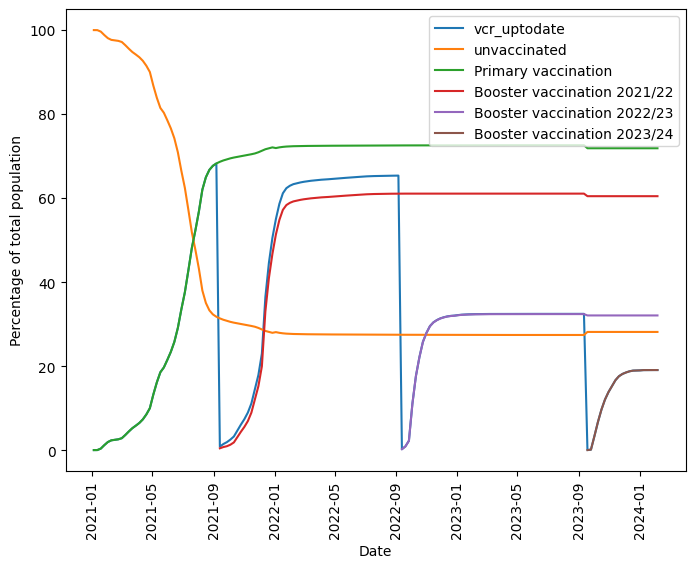

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(DKvac['Date'], DKvac['vcr_uptodate'],label='vcr_uptodate')
plt.plot(DKvac['Date'], DKvac['unvac'],label='unvaccinated')
plt.plot(DKvac['Date'], DKvac['pri_vcr'],label='Primary vaccination')
plt.plot(DKvac['Date'], DKvac['bo_21_vcr'],label='Booster vaccination 2021/22')
plt.plot(DKvac['Date'], DKvac['bo_22_vcr'],label='Booster vaccination 2022/23')
plt.plot(DKvac['Date'], DKvac['bo_23_vcr'],label='Booster vaccination 2023/24')
plt.legend(loc='upper right')
plt.ylabel('Percentage of total population')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.savefig("vcr.png")

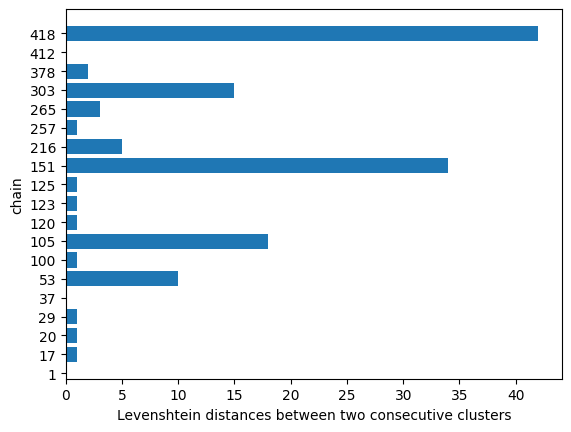

<Figure size 640x480 with 0 Axes>

In [90]:
DK2a = DK2a.sort_values('chain')
y = DK2a['chain'].astype(int).astype(str)
DK2a['LD1'] = pd.to_numeric(DK2a['LD1'], errors = 'coerce')
x = DK2a['LD1']
barlabels = ['D614G','D614G','D614G','D614G','Alpha','Delta','Delta','Delta','BA.2', 'BA.5','BA.5','BA.5','XBB.1.5','XBB.1.9.2','BA.2.86','BA.2.86']
fig, ax = plt.subplots()
ax.barh(y,x)#, label=barlabels)
ax.set_xlabel('Levenshtein distances between two consecutive clusters')
ax.set_ylabel('chain')
plt.show()
plt.savefig('LD1.png')


In [ ]:
DK2a.info()

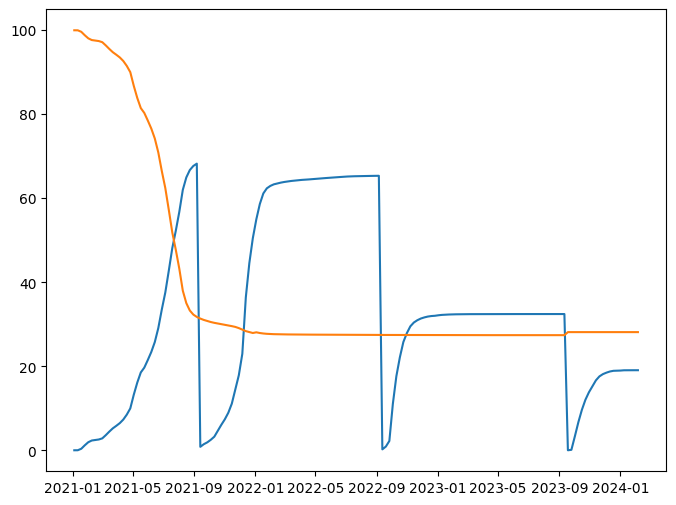

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(DKvac['Date'], DKvac['vcr_uptodate'],label='vcr_uptodate')
plt.plot(DKvac['Date'], DKvac['unvac'],label='unvaccinated')

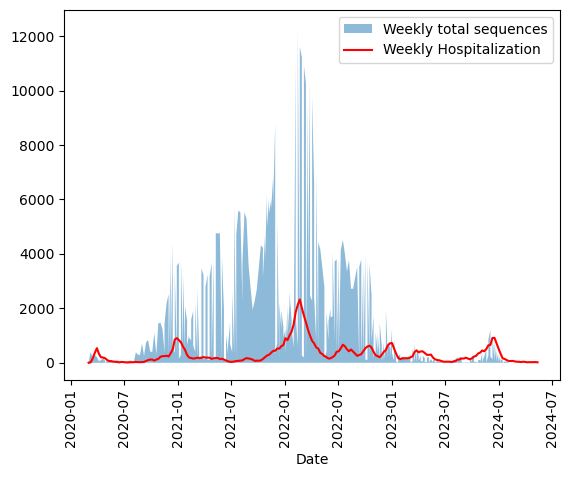

In [146]:
dfhosp = dfhosp.sort_values('Date')
DK_ML = DK_ML.sort_values('Date')
plt.fill_between(DK_ML['Date'], DK_ML['Sequence_total'], label = "Weekly total sequences", alpha = 0.5)
plt.plot(dfhosp['Date'], dfhosp['Hospitalization'], label = "Weekly Hospitalization", c='red')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.savefig("seq_hosp.png")